# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [1]:
import mne
import matplotlib.pyplot as plt
import pyxdf
import numpy as np
from glob import glob

## Path to dataset

In [2]:
SUBJECT = 'ruomin'
DATA_PATH = f'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/sub-{SUBJECT}/'
XDF_FILES = glob(DATA_PATH + '**/*/*.xdf')
XDF_FILES = sorted(XDF_FILES) # to sort by run#
XDF_FILES

['/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/sub-ruomin/ses-S001/eeg/sub-ruomin_ses-S001_task-Default_run-001_eeg.xdf',
 '/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/sub-ruomin/ses-S001/eeg/sub-ruomin_ses-S001_task-Default_run-002_eeg.xdf',
 '/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/sub-ruomin/ses-S001/eeg/sub-ruomin_ses-S001_task-Default_run-003_eeg.xdf',
 '/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/sub-ruomin/ses-S001/eeg/sub-ruomin_ses-S001_task-Default_run-004_eeg.xdf',
 '/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/sub-ruomin/ses-S001/eeg/sub-ruomin_ses-S001_task-Default_run-005_eeg.xdf']

875674.4782834494 	 ['CGX Quick-32r Q32r-0524']
875674.4782821189 	 ['CGX Quick-32r Q32r-0524 Impedance']
875678.0029253346 	 ['Car_Racing_ObstacleData']
875676.9647723328 	 ['KeyBoardStreamingT2']
875674.4782821189 	 <== earliest
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
Eff. Sampling Rate: 499.9498786618833 Hz
(67675, 37)
Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
Eff. Sampling Rate: 499.9498630760212 Hz
Stream Name: Car_Racing_ObstacleData	Type: Gaming
Stream Name: KeyBoardStreamingT2	Type: Markers
875911.4775603042 	 ['CGX Quick-32r Q32r-0524 Impedance']
875911.4775617261 	 ['CGX Quick-32r Q32r-0524']
875914.6728470076 	 ['Car_Racing_ObstacleData']
875913.6419722715 	 ['KeyBoardStreamingT2']
875911.4775603042 	 <== earliest
Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
Eff. Sampling Rate: 499.9784621758511 Hz
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
Eff. Sampling Rate: 499.9784520110105 Hz
(54894, 37)
Stream Name: Car_Racing_Obstacl

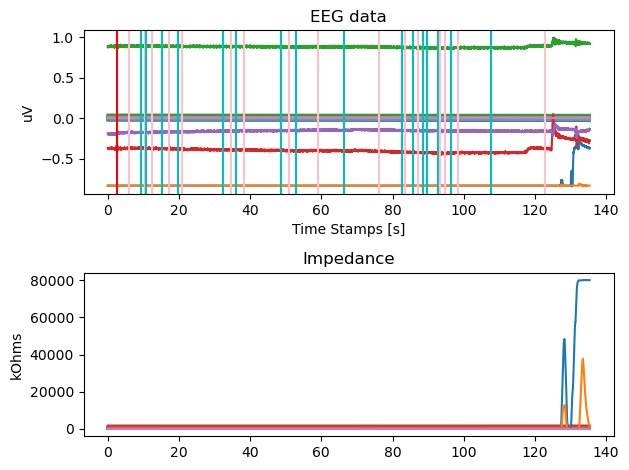

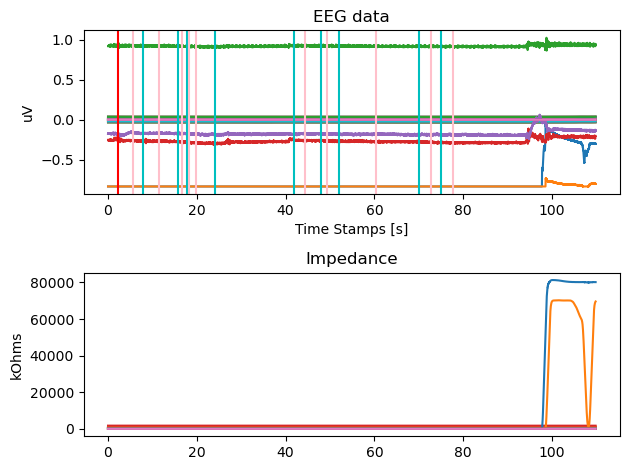

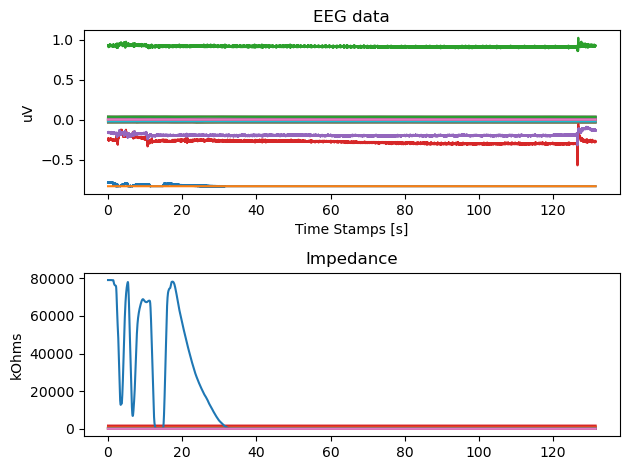

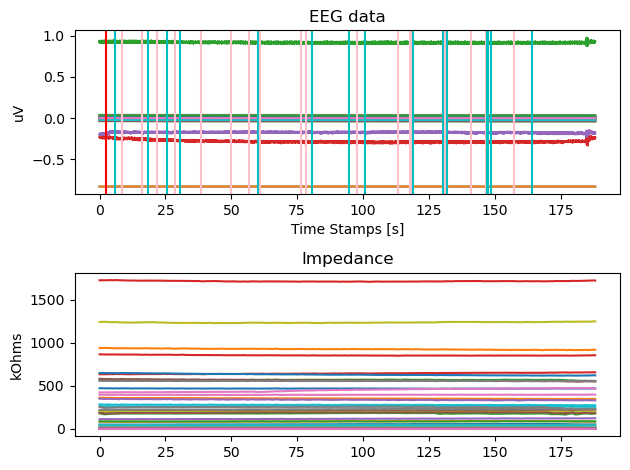

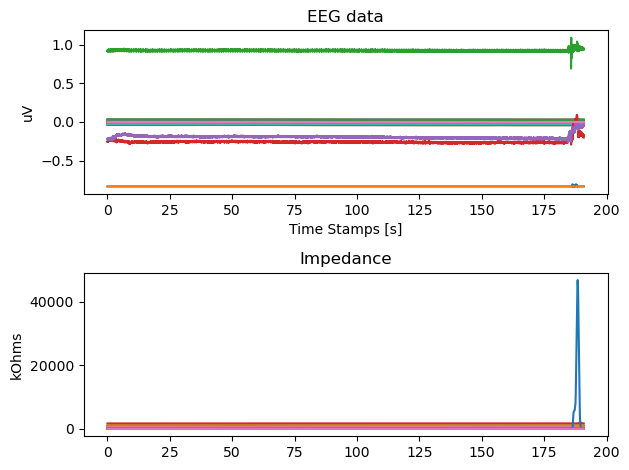

In [19]:
ALL_EEG = []
ALL_Z = []
ALL_LSL = []

# Load each XDF file for a given subject
for XDF in XDF_FILES:
    streams, header = pyxdf.load_xdf(XDF)
    
    # Get the first time stamp across all streams (read from time_stamps)
    first_timestamps = []

    for s in streams: # loop through remaining streams
        s_name = s['info']['name']
        t0 = s['time_stamps'][0]
        print(t0, '\t', s_name)

        first_timestamps.append(t0)

    first_timestamp = min(first_timestamps)
    print(first_timestamp, '\t', '<== earliest') 
    
    # Identify EEG data and impedance streams
    for s in streams:
        s_name = s['info']['name'][0]
        s_type = s['info']['type'][0]
        print(f'Stream Name: {s_name}\tType: {s_type}')

        # Get the EEG data stream for CGX
        if ('CGX' in s_name) and (s_type == 'EEG'):
            eeg_data = s['time_series']
            eeg_t = s['time_stamps'] - first_timestamp # offset first time stamp to t=0
            eeg_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
            eeg_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
            eeg_sfreq = s['info']['effective_srate']
            #print(f'Channels: {eeg_ch_names}')
            #print(f'Unit: {eeg_ch_units}')
            print(f'Eff. Sampling Rate: {eeg_sfreq} Hz')
            print(eeg_data.shape)
            
            # Rescale to V for importing into MNE
            if 'microvolts' in eeg_ch_units:
                eeg_data /= 1e6
                   
            ALL_EEG.append(eeg_data)

        # Get the impedance data stream for CGX
        elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
            z_data = s['time_series']
            z_t = s['time_stamps'] - first_timestamp
            z_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
            z_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
            z_sfreq = s['info']['effective_srate']
            #print(f'Channels: {z_ch_names}')
            #print(f'Unit: {z_ch_units}')
            print(f'Eff. Sampling Rate: {z_sfreq} Hz')
            
            
            ALL_Z.append(z_data)

        # Keyboard events
        else: # (s_type == 'Markers') or (s_type == 'Gaming'):
            events = s['time_series']
            events_t = s['time_stamps'] - first_timestamp
    
            ALL_LSL.append((events_t, events))
    
    # Plot EEG data
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(eeg_t, eeg_data)
    ax[0].set_ylabel('uV')
    ax[0].set_xlabel('Time Stamps [s]')
    ax[0].set_title('EEG data')

    # Plot event markers
    for i in range(len(events)):
        event_t = events_t[i]
        event_v = events[i][0]
        event_type = events[i][1]

        if event_type == 'left':
            ax[0].axvline(x = event_t, c='pink')
        elif event_type == 'right':
            ax[0].axvline(x = event_t, c='c')
        elif event_type == 'enter':
            ax[0].axvline(x = event_t, c='r')

    ax[1].plot(z_t, z_data)
    ax[1].set_ylabel('kOhms')
    ax[1].set_title('Impedance')

    plt.tight_layout()

plt.show()

In [20]:
len(streams)

4

In [21]:
streams[3]['info']

defaultdict(list,
            {'name': ['Car_Racing_ObstacleData'],
             'type': ['Gaming'],
             'channel_count': ['3'],
             'channel_format': ['float32'],
             'source_id': ['car_racing_game_metadata'],
             'nominal_srate': ['0.000000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['13272.42056816600'],
             'uid': ['d782bfc5-eb96-4226-8940-fc6fce70b7fc'],
             'session_id': ['default'],
             'hostname': ['MacBook-Pro.local'],
             'v4address': [None],
             'v4data_port': ['16573'],
             'v4service_port': ['16573'],
             'v6address': [None],
             'v6data_port': ['16573'],
             'v6service_port': ['16573'],
             'desc': [None],
             'stream_id': 4,
             'effective_srate': 0})

In [22]:
len(ALL_LSL)

10

# Stitch all the datasets together
(skip for now)

In [23]:
if 0:
    eeg_stacked = np.vstack(ALL_EEG)
    z_stacked = np.vstack(ALL_EEG)
    lsl_stacked = np.vstack(ALL_EEG)

# Prepare to import data to mne

In [27]:
# Just use the last run's channel names, since the setup is the same across runs
ch_names = eeg_ch_names + z_ch_names
ch_names

['AF7',
 'Fpz',
 'F7',
 'Fz',
 'T7',
 'FC6',
 'Fp1',
 'F4',
 'C4',
 'Oz',
 'CP6',
 'Cz',
 'PO8',
 'CP5',
 'O2',
 'O1',
 'P3',
 'P4',
 'P7',
 'P8',
 'Pz',
 'PO7',
 'T8',
 'C3',
 'Fp2',
 'F3',
 'F8',
 'FC5',
 'AF8',
 'A2',
 'ExG 1',
 'ExG 2',
 'ACC32',
 'ACC33',
 'ACC34',
 'Packet Counter',
 'TRIGGER',
 'AF7-Z',
 'Fpz-Z',
 'F7-Z',
 'Fz-Z',
 'T7-Z',
 'FC6-Z',
 'Fp1-Z',
 'F4-Z',
 'C4-Z',
 'Oz-Z',
 'CP6-Z',
 'Cz-Z',
 'PO8-Z',
 'CP5-Z',
 'O2-Z',
 'O1-Z',
 'P3-Z',
 'P4-Z',
 'P7-Z',
 'P8-Z',
 'Pz-Z',
 'PO7-Z',
 'T8-Z',
 'C3-Z',
 'Fp2-Z',
 'F3-Z',
 'F8-Z',
 'FC5-Z',
 'AF8-Z',
 'A2-Z',
 'ExG 1-Z',
 'ExG 2-Z',
 'ACC32-Z',
 'ACC33-Z',
 'ACC34-Z',
 'Packet Counter-Z',
 'TRIGGER-Z']

(Manually) Identify each channel's type for importing data to mne:

In [28]:
ch_types = []
ch_types.extend(['eeg']*(29+1)) # first 29 channels are EEG, and A2
ch_types.extend(['misc']*(2+3+1)) # ExG x2, ACC x3, Packet Counter
ch_types.extend(['stim']) # Trigger channel (unused)
ch_types.extend(['misc']*(len(z_ch_names))) # all impedance channels

Make an info object for importing data to mne:

https://mne.tools/stable/generated/mne.create_info.html

In [30]:
info = mne.create_info(
    ch_names = ch_names,
    sfreq = eeg_sfreq,
    ch_types = ch_types,
)

Import the data as a raw array:

https://mne.tools/stable/generated/mne.io.RawArray.html

In [35]:
ALL_RAWS = []

for run_idx in range(len(ALL_EEG)):
    
    # Pull out eeg data for this run
    eeg_data = ALL_EEG[run_idx]
    z_data = ALL_Z[run_idx]
    eeg_z_data = np.hstack((eeg_data, z_data))
    # print(eeg_z_data.shape)
    
    # Make an MNE object
    raw = mne.io.RawArray(
        data = eeg_z_data.T, # mne expects (n_channels, n_times)
        info = info,
    )
    
    # Add montage
    raw.info.set_montage('standard_1020', match_case=False)

    # Get annotations from key presses
    k_events_t, k_events = ALL_LSL[2*run_idx -1]
    
    print(k_events_t.shape)
    print(k_ev_od)
    key_annot = mne.Annotations(
        onset = k_events_t,
        duration = np.zeros_like(k_events_t), # setting durations to 0 to just label event onsets
        description = k_ev_id,
    )
    
    # Get annotations from game
    g_events_t, g_ev_id = ALL_LSL[2*run_idx]
    game_annot = mne.Annotations(
        onset = g_events_t,
        duration = np.zeros_like(g_events_t), # setting durations to 0 to just label event onsets
        description = g_ev_id,
    )

    # Add all these annotations to the raw object
    raw.set_annotations(key_annot + game_annot)

    ALL_RAWS.append(raw.copy())

Creating RawArray with float64 data, n_channels=74, n_times=67675
    Range : 0 ... 67674 =      0.000 ...   135.347 secs
Ready.


ValueError: Description must be a one dimensional array, got 2.

## Visualize the 10-20 channel montage

In [ ]:
# Plot the montage
mne.viz.plot_montage(ALL_RAWS[0].info.get_montage())

# Add annotations from marker stream

In [ ]:
ev_id = [ev[1] for ev in events]
ev_id

https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html

In [ ]:
lsl_annot = mne.Annotations(
    onset = events_t,
    duration = np.zeros_like(events_t), # setting durations to 0 to just label event onsets
    description = ev_id,
)

raw.set_annotations(lsl_annot)

In [ ]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {
    'eeg': 100e-6,
    'misc': 100
} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = []
raw.info['bads'] = bad_chans

PLOT_WINDOW_START_s = 0
PLOT_WINDOW_DUR_s = 20

raw.plot(
    scalings = scalings,
    #butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Manually reject bad data segments

In [ ]:
bad_annot = mne.Annotations(
    onset = [125, ],
    duration = [20, ], # setting durations to 0 to just label event onsets
    description = "bad",
)

#raw.set_annotations(raw.annotations + bad_annot)
raw.set_annotations(lsl_annot + bad_annot)

In [ ]:
# Remove any erroneous annotations (if needed)
# raw.annotations[5]
# raw.annotations.delete(5)

In [ ]:
# Plot again
raw.plot(
    scalings = scalings,
    butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Power Spectra
(before filtering)

In [ ]:
raw.compute_psd(n_fft = 1024).plot(average = False)

Let's filter the data:

In [ ]:
# Notch filter
raw_filt = raw.copy().notch_filter( # make a copy of the array to avoid modifying in place
    freqs = [60, 120, 180, 240]
)

# Highpass filter
raw_filt = raw_filt.filter( # make a copy of the array to avoid modifying in place
    l_freq = 1, # lower cut-off, in Hz
    h_freq = None, # upper cut-off, in Hz
)

n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
raw_filt.compute_psd(
    # picks= picks,
    # fmin = 0, # lower limit to plot
    # fmax = 60, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

# Identify any bad channels

In [ ]:
## Update scalings if needed
scalings['eeg'] = 200e-6 
# scalings['eog'] = 500e-6
# scalings['misc'] = 100

raw_filt.info.bads = [] #'Oz', 'O1', , 'Fp2', 'F7', 'P3'] # ideally could label bad segments instead of dropping channels

# Drop bad channels from visual examination before running ICA
raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info.bads)

raw_filt_drop_bad.plot(
    scalings = scalings,
    butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

## Re-reference to average (or just A2)
https://mne.tools/stable/generated/mne.set_eeg_reference.html

In [ ]:
raw_filt_drop_bad_rref, _ = mne.set_eeg_reference(
    raw_filt_drop_bad, 
    ref_channels=['A2'], #'average',
)

raw_filt_drop_bad_rref.plot(
    scalings=scalings,
    butterfly=True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Run ICA to remove artifacts
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py

In [ ]:
from mne.preprocessing import ICA

# Make an ICA object
ica = ICA(
    #n_components = 29, # number of prinicipal components passed to ICA
    random_state = 23, # seed for numpy RNG
    #method = 'infomax', # can use 'fastica' or 'picard' too
)

# Run ICA
ica.fit(raw_filt_drop_bad_rref)

## Plot ICA components over time

In [ ]:
%matplotlib widget
ica.plot_sources(
    raw_filt_drop_bad_rref,
    start = PLOT_WINDOW_START_s,
    stop = PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s,
)

## Topomaps for each ICA component

In [ ]:
suspect_ica_components = [
    0, # eye blinks
    3, # pulse
]

ica.plot_properties(
    raw_filt_drop_bad_rref,
    #picks = suspect_ica_components, # select ICA components to plot topomaps for
)

plt.show()

## Remove suspect ICA components

In [ ]:
PLOT_WINDOW_START_s = 35
PLOT_WINDOW_DUR_s = 30

ica.plot_overlay(
    raw_filt_drop_bad,
    exclude = suspect_ica_components,
    
    start = int(raw_filt_drop_bad.info['sfreq']) * PLOT_WINDOW_START_s, # this is index, not seconds
    stop = int(raw_filt_drop_bad.info['sfreq']) * (PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s),
)


## Project back to channel space

In [ ]:
raw_ica = ica.apply(
    raw_filt_drop_bad, 
    exclude=suspect_ica_components, # ICA components to drop
)

In [ ]:
raw_ica.plot(
    scalings = scalings,
    butterfly = True,
    duration = PLOT_WINDOW_DUR_s,
    start = PLOT_WINDOW_START_s,
)

# Lets find events from annotations

In [ ]:
events, event_id = mne.events_from_annotations(raw_ica)

In [ ]:
events

In [ ]:
event_id

In [ ]:
eps = mne.Epochs(
    #raw_filt,
    raw_ica,
    events = events, 
    event_id = event_id, 
    tmin=-0.5,
    tmax=.5,
    baseline=None,
)

%matplotlib inline

for ev_id in ['left', 'right']:
    eps[ev_id].plot_image(
        #picks = [],
        combine='mean'
    )

In [ ]:
%matplotlib widget

for ev_id in event_id:
    eps[ev_id].average(
        # picks = []
    ).plot_joint()

In [ ]:
ica.fit(eps)

In [ ]:
%matplotlib widget
ica.plot_sources(
    eps,
    #start = PLOT_WINDOW_START_s,
    #stop = PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s,
)

In [ ]:
ica.plot_properties(
    eps,
    picks = range(28), # select ICA components to plot topomaps for
)


In [ ]:
reject_criteria = dict(
    eeg=200e-6,  # 100 µV
)  # 200 µV

In [ ]:
epochs = mne.Epochs(
    raw_ica,
    events,
    tmin=-0.5,
    tmax=0.5,
    #reject_tmax=0,
    reject=reject_criteria,
    #flat=flat_criteria,
    #reject_by_annotation=False,
    preload=True,
)
epochs.plot_drop_log()

In [ ]:
%matplotlib widget

for ev_id in [2, 3]:
    epochs[ev_id].average(
        # picks = []
    ).plot_joint()

# To Do
- Notch out power supply noise and look at EEG bands